# Titanic Competition: Survival Data


There are several excellent notebooks to study data science competition entries. However many will skip over the explanation on how the solution is developed. The objective of this notebook is to make the Titanic problem as simple and clear as possible.

## Question and problem definition

> Knowing from a [training data](https://www.kaggle.com/c/titanic/data) set that contains the list passengers who survived the Titanic ship sinking, we create a model that determines, based on a given test dataset, if future passengers will survive.

## On To The Python Code

In [26]:
# Python libraries for data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# Python visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Python machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Acquire data

The Python Pandas library helps us work with our datasets. We start by acquiring the training and testing datasets into Pandas DataFrames. We also combine these datasets to run certain operations on both datasets together.

In [27]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df] 
# Here we are combining both datasets. 
# We do it to perform one operation on both datasets simultaneouly
# throughout this notebook, you'll see the "for" function when we are performing this operation

## Analyze by describing data

The Pandas library from Python also helps describe the variables in our dataset

Which features are available in the dataset?**

Noting the feature names for directly manipulating or analyzing these. For a description of these variables, head to the [Kaggle data page here](https://www.kaggle.com/c/titanic/data) and scroll through the *Data Description* section.

In [28]:
train_df.columns.values # This shows the column titles for the training set

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

**Which features are categorical?**

These values classify the samples into sets of similar samples. The category is usually a non-numerical classification value.

- Categorical Nominal: Survived, Sex, Embarked, and Pclass.

**Which features are numerical?**

Which features are numerical? These values usually change from sample to sample. They can be discrete, continuous, or timeseries based. 

- Numerical Continous: Age, Fare. 
- Numerical Discrete: SibSp, Parch.

In [29]:
# preview the training set data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Which features are mixed data types?**

Fetaures that have alphanumerical values. These are candidates for the correcting goal.  We can either correct these, or drop them completely.

- Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric.

**Which features may contain errors or typos?**

This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.

- The Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.

In [30]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


**Which features contain null or empty values?**

These will require correcting.

- The Cabin, Age, and Embarked features contain a number of empty values for the training dataset. They are represented as "NaN" on the data.
- Cabin and Age are incomplete for the test dataset.

In [31]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

Looks like the features Age, Cabin, and Embarked contain rows with empty values

**What are the data types for various features?**

- Seven features are integer or floats. Six in case of test dataset. -----> Numerical
- Five features are strings (object). -----> Categorical

In [32]:
train_df.describe() # Describing numerical data
# Review survived rate
# Review Parch distribution using `percentiles=[.75, .8]`
# SibSp distribution `[.68, .69]`
# Age and Fare `[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99]`

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [33]:
# Now we look at categorical data.
train_df.describe(include=['O']) # The include=['O'] parameter prints out only the object or string columns 

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Fleming, Miss. Margaret",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


**What is the distribution of categorical features?**

- Names are unique across the dataset (count=unique=891)
- Sex variable as two possible values with 65% male (top=male, freq=577, count=891).
- Cabin values have several duplicates across samples and only 204 samples.
- Embarked takes three possible values. S port used by most passengers (top=S)
- Ticket feature has 22% of duplicate values (unique=681).

In [34]:
# We use the .groupby methosd  to sort the data by Pclass.  Then we take the mean of the Survived column
# for each value of Pclass.  Pclass is the passnger class: 1st, 2nd, or 3rd.
# The as_index=False parameter makes sure the Pclass column is not returned as the index
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


This method lets us know the percentage of passengers who survived by class.

In [35]:
# We use the same .groupby method with sex.
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [36]:
# We use the same .groupby method with SibSp. SibSp is the number of siblings and spouse accompanying a passenger.
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [37]:
# We use the same .groupby method with Parch. Parch is the number of parents and children accompanying a passenger.
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## Analyze the data by pivoting features using the .groupby method

To confirm some of our observations and assumptions, we quickly analyzed our feature correlations by pivoting features against the Survived column with the .groupby method. We can only do so at this stage for features which do not have any empty values. 
- **Pclass** We observe significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). We decide to include this feature in our model.
- **Sex** We confirm the observation during problem definition that Sex=female had very high survival rate at 74% (classifying #1).
- **SibSp and Parch** These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features.

## Analyze by visualizing data

Now we can continue confirming some of our assumptions using visualizations for analyzing the data.

### Correlating numerical features

Let us start by understanding correlations between numerical features and our solution goal (Survived).

A histogram chart is useful for analyzing continuous numerical variables like Age where banding or ranges will help identify useful patterns. The histogram can indicate distribution of samples using automatically defined bins or equally ranged bands. This helps us answer questions relating to specific bands (Did infants have better survival rate?)

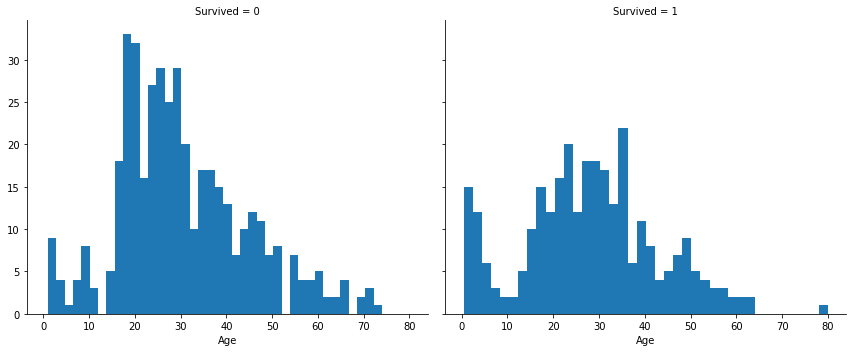

In [38]:
# We plot two histograms of age and separate them by Survived 1 or 0 for yes or no.
g = sns.FacetGrid(train_df, col='Survived',size=5, aspect=1.2)
g.map(plt.hist, 'Age', bins=40)

Note that y-axis in the histogram represents the count of samples or passengers.

**Observations.**

- Most Infants (Age <=4) survived. 
- Oldest passengers (Age = 80) survived.
- Large number of 15-25 year olds did not survive.
- Most passengers are in 15-35 age range.

**Decisions.**

This simple analysis confirms our assumptions as decisions for subsequent workflow stages.

- We should consider Age (our assumption classifying #2) in our model training.
- Complete the Age feature for null values (completing #1).
- We should band age groups (creating #3).

### Correlating numerical and ordinal features

We can combine multiple features for identifying correlations using a single plot. This can be done with numerical and categorical features which have numeric values.

**Observations.**

- Pclass=3 had most passengers, however most did not survive. 
- Infant passengers in Pclass=2 and Pclass=3 mostly survived. 
- Most passengers in Pclass=1 survived. 
- Pclass varies in terms of Age distribution of passengers.

**Decisions.**

- Consider Pclass for model training.

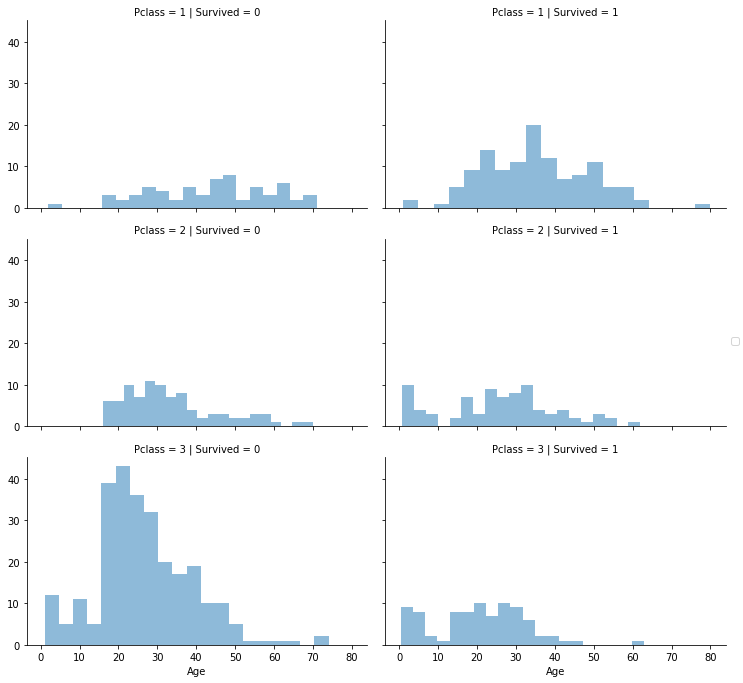

In [39]:
# Following are histogram plots number of Surviver (or not) vs Age.  They are separated by passenger class
# and whether they survived (or not).
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=3.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### Correlating categorical features

Now we can correlate categorical features with our solution goal.

**Observations.**

- Female passengers had much better survival rate than males.
- Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
- Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports.
- Ports of embarkation have varying survival rates for Pclass=3 and among male passengers.

**Decisions.**

- Add Sex feature to model training.
- Complete and add Embarked feature to model training.

C:\Users\asusz\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\asusz\Anaconda3\lib\site-packages\seaborn\axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


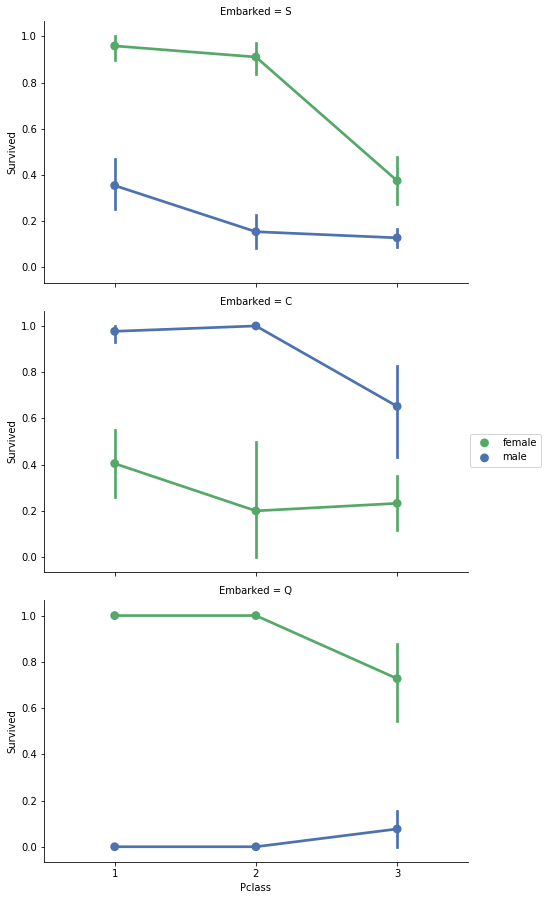

In [40]:
# A point plot represents an estimate of central tendency for a numeric variable by the position of scatter
# plot points and provides some indication of the uncertainty around that estimate using error bars.
# Parameters: x, y, hue

grid = sns.FacetGrid(train_df, row='Embarked', size=4.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

We can see the correlation between Gender, Class, and Embarked Port.  Almost all females on first class who embarked on ports C & Q survived.

## Wrangle data

We have made several assumptions regarding our training dataset. So far we did not have to change a single feature or value to arrive at these. We will now execute our assumptions for the correcting, creating, and completing goals.

### Dropping features

By dropping features we are dealing with fewer data points. 

Based on our assumptions and decisions we want to drop the Cabin and Ticket features.  These 2 features have little to no influence on whether a passenger survived or not.

Note that where applicable we perform operations on both training and testing datasets together to stay consistent.

In [41]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

We can see that the test and train datasets dropped  2 columns each

### Creating a new feature by extracting from existing

We want to determine if the Name feature can be engineered to extract titles and test the correlation between titles and survival. This is before dropping Name and PassengerId features.

In the following code we extract Title feature using regular expressions.  

In [42]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
# The "expand=False" option returns a DataFrame.    
    
    
pd.crosstab(train_df['Title'], train_df['Sex'])
# The crosstabe method computes a simple cross-tabulation of two (or more) factors. By default computes
# a frequency table of the factors unless an array of values and an aggregation function are passed

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We can replace many titles with a more common name or classify them as "Other".

In [43]:
# The for loop executes the code every time the column 'Title' is present inside the dataset.
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
# Here we replace uncommon Titles with the value "Other"

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Other,0.347826


We can convert the categorical titles to ordinal.

In [44]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

# The for loop executes the code every time the column 'Title' is present inside the dataset.
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping) # We use the map function to map the numbers
                                                           # to their respective Title.
    dataset['Title'] = dataset['Title'].fillna(0)
    # Rows marked as NaN are filled with zeroes.
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1.0


In [ ]:
test_df.head()

Now we can safely drop the Name feature from training and testing datasets. We also do not need the PassengerId feature in the training dataset.

In [45]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

### Converting a categorical feature

Now we can convert features which contain strings to numerical values. This is required by most model algorithms. Doing so will also help us in achieving the feature completing goal.

Let us start by converting Sex feature to a new feature called Gender where female=1 and male=0.

In [46]:
# We could have also used the .get_dummies method here
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} )

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1.0
1,1,1,1,38.0,1,0,71.2833,C,3.0
2,1,3,1,26.0,0,0,7.9250,S,2.0
3,1,1,1,35.0,1,0,53.1000,S,3.0
4,0,3,0,35.0,0,0,8.0500,S,1.0


In [47]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,0,34.5,0,0,7.8292,Q,1.0
1,893,3,1,47.0,1,0,7.0000,S,3.0
2,894,2,0,62.0,0,0,9.6875,Q,1.0
3,895,3,0,27.0,0,0,8.6625,S,1.0
4,896,3,1,22.0,1,1,12.2875,S,3.0


### Completing a numerical continuous feature

Now we should start estimating and completing features with missing or null values. We will first do this for the Age feature.


In our case we note correlations among Age, Gender, and Passgener Class. Guess Age values using median values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on.

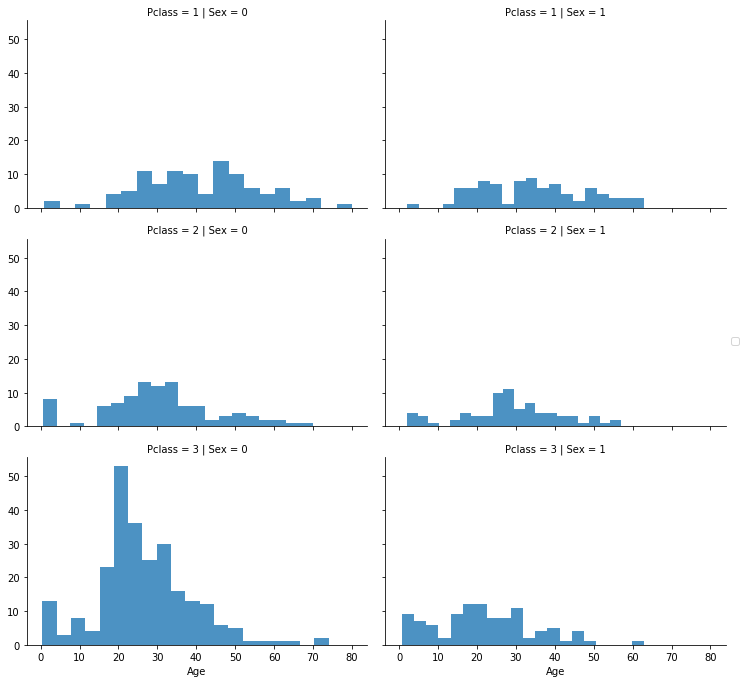

In [48]:
# Plots of Age per Passenger Class for Male and Female

#grid = sns.FacetGrid(train_df, col='Pclass', hue='Sex')
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=3.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.8, bins=20)
grid.add_legend()

Let us start by preparing an empty array to contain guessed Age values based on Pasenger Class and Gender combinations.

In [49]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations.

In [50]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), 'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1.0
1,1,1,1,38,1,0,71.2833,C,3.0
2,1,3,1,26,0,0,7.9250,S,2.0
3,1,1,1,35,1,0,53.1000,S,3.0
4,0,3,0,35,0,0,8.0500,S,1.0


In [52]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,0,34,0,0,7.8292,Q,1.0
1,893,3,1,47,1,0,7.0000,S,3.0
2,894,2,0,62,0,0,9.6875,Q,1.0
3,895,3,0,27,0,0,8.6625,S,1.0
4,896,3,1,22,1,1,12.2875,S,3.0


Let us create Age bands and determine correlations with Survived. AgeBand is a new column on the training set that specifies a range of ages.  Here, we are splitting that range into 5 groups.

In [53]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
# The cut function segments and sorts data values into bins. This function is also useful for going from
# a continuous variable to a categorical variable. For example, cut could convert ages to groups 
# of age ranges. 
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


Let us replace Age with ordinals based on these bands. Age ranges will have values from 0 to 4.

In [54]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1.0,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3.0,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2.0,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3.0,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1.0,"(32.0, 48.0]"


We can now drop the AgeBand feature we recently created.

In [55]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1.0
1,1,1,1,2,1,0,71.2833,C,3.0
2,1,3,1,1,0,0,7.9250,S,2.0
3,1,1,1,2,1,0,53.1000,S,3.0
4,0,3,0,2,0,0,8.0500,S,1.0


### Creating new feature combining existing features

We can create a new feature for FamilySize which combines Parch and SibSp (parents, siblings, children, spouses). This will enable us to drop Parch and SibSp from our datasets. We well create a new column that will just list if a passneger was alone or not.

In [56]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


We can create another feature called IsAlone.

In [57]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


Let us drop Parch, SibSp, and FamilySize features in favor of IsAlone.

In [58]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1.0,0
1,1,1,1,2,71.2833,C,3.0,0
2,1,3,1,1,7.9250,S,2.0,1
3,1,1,1,2,53.1000,S,3.0,0
4,0,3,0,2,8.0500,S,1.0,1


### Now our Dataset is cleaner

We can also create an artificial feature combining Passenger Class and Age.  Rember, the Age column now represents a range of Ages.

In [59]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### Completing a categorical feature

Embarked feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. We simply fill these with the most common occurance.

In [60]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [61]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### Converting categorical features to numeric

We can now convert the EmbarkedFill feature by creating a new numeric Port feature.

In [62]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1.0,0,3
1,1,1,1,2,71.2833,1,3.0,0,2
2,1,3,1,1,7.9250,0,2.0,1,3
3,1,1,1,2,53.1000,0,3.0,0,2
4,0,3,0,2,8.0500,0,1.0,1,6


### Quick completing and converting a numeric feature

We can now complete the Fare feature missing values in the test dataset using the median. We do this in a single line of code.

We may also want round off the fare to two decimals as it represents currency.

In [63]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1.0,1,6
1,893,3,1,2,7.0000,0,3.0,0,6
2,894,2,0,3,9.6875,2,1.0,1,6
3,895,3,0,1,8.6625,0,1.0,1,3
4,896,3,1,1,12.2875,0,3.0,0,3


We can now create FareBand, which is a range of fares.

In [64]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


Convert the Fare feature to ordinal values based on the FareBand.

In [65]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1.0,0,3
1,1,1,1,2,3,1,3.0,0,2
2,1,3,1,1,1,0,2.0,1,3
3,1,1,1,2,3,0,3.0,0,2
4,0,3,0,2,1,0,1.0,1,6
5,0,3,0,1,1,2,1.0,1,3
6,0,1,0,3,3,0,1.0,1,3
7,0,3,0,0,2,0,4.0,0,0
8,1,3,1,1,1,0,3.0,0,3
9,1,2,1,0,2,1,3.0,0,0


And the test dataset.

In [66]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1.0,1,6
1,893,3,1,2,0,0,3.0,0,6
2,894,2,0,3,1,2,1.0,1,6
3,895,3,0,1,1,0,1.0,1,3
4,896,3,1,1,1,0,3.0,0,3
5,897,3,0,0,1,0,1.0,1,0
6,898,3,1,1,0,2,2.0,1,3
7,899,2,0,1,2,0,1.0,0,2
8,900,3,1,1,0,1,3.0,1,3
9,901,3,0,1,2,0,1.0,0,3


## Model, predict and solve

Now we are ready to train a model that predicts the solution.   Our problem is a classification.. We want to identify the relationship between the output (Survived or not) with the input variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria, Supervised Learning plus Classification, we can narrow down our choice of models to a few. These include:

- Logistic Regression
- KNN or k-Nearest Neighbors
- Support Vector Machines
- Naive Bayes classifier
- Decision Tree
- Random Forrest
- Perceptron
- Artificial neural network
- RVM or Relevance Vector Machine

In [67]:
#We drop 'Survived' and 'PassengerID' from the test and training features.
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1)
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

Logistic Regression is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution.

Note the confidence score generated by the model based on our training dataset.

In [68]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
# Here we fit our model to the training data using Logistic Regression

Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
# The .score methond returns the accuracy of the test data to the training model.
acc_log

81.59

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).


In [69]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,1.867882
5,Title,0.796155
6,IsAlone,0.445409
4,Embarked,0.328329
3,Fare,-0.097046
7,Age*Class,-0.103038
2,Age,-0.206102
0,Pclass,-1.224695


- Sex is highest positivie coefficient, implying as the Sex value increases (male: 0 to female: 1), the probability of Survived=1 increases the most.
- Inversely as Pclass increases, probability of Survived=1 decreases the most.
- This way Age*Class is a good artificial feature to model as it has second highest negative correlation with Survived.
- So is Title as second highest positive correlation.

Next we model using Support Vector Machines. Given a set of training samples, each marked as belonging to one or the other of **two categories**, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier.

In [70]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.84

In pattern recognition, the k-Nearest Neighbors algorithm (or k-NN for short) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor. 

KNN confidence score is better than Logistics Regression but worse than SVM.

In [71]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

83.16

In machine learning, naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. 

The model generated confidence score is the lowest among the models evaluated so far.

In [72]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

77.78

This model uses a decision tree as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. 

The model confidence score is the highest among models evaluated so far.

In [73]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.64

The next model Random Forests is one of the most popular. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators=100) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

The model confidence score is the highest among models evaluated so far. We decide to use this model's output (Y_pred) for creating our competition submission of results.

In [74]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.64

### Model evaluation

We can now rank our evaluation of all the models to choose the best one for our problem. While both Decision Tree and Random Forest score the same, we choose to use Random Forest as they correct for decision trees' habit of overfitting to their training set. 

In [75]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.64
5,Decision Tree,86.64
0,Support Vector Machines,83.84
1,KNN,83.16
2,Logistic Regression,81.59
4,Naive Bayes,77.78


In [76]:
Y_pred = random_forest.predict(X_test)

In [79]:
# The code will below makes the submission file that is uploaded into Kaggle.
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)